## Salish Sea Maps
This notebook plots various maps relevant to the SalishSeaCast project. The first map is a general study area map. The second map shows the model domain and bathymetry. The third map shows the Strait of Georgia with relevant observation platform locations overplotted.

In [383]:
from salishsea_tools import nc_tools, viz_tools, utilities
import matplotlib.pyplot as plt
import shapefile
import struct
import h5py
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Rectangle, Polygon
from matplotlib import gridspec, cm
from scipy.io import loadmat
from importlib import reload, util
import cmocean
import numpy as np
import xarray as xr
import os

# Load Michael's bathy tools
spec = util.spec_from_file_location(
    'bathy_readers.py', '/ocean/mdunphy/MEOPAR/analysis-michael/bathymetry/bathy_readers.py',
)
bathy_readers = util.module_from_spec(spec)
spec.loader.exec_module(bathy_readers)

%matplotlib inline

In [561]:
plt.rcParams['font.size'] = 13

#### Boilerplate Functions
Annotations

In [2]:
def plot_annotations(ax, m, annotations, zorder=None):
    """
    """
    
    # Plot Locations
    for annotation_label, annotation in annotations.items():
        ax.text(*annotation['text'], annotation_label, transform=ax.transAxes,
                fontsize=annotation['font']+1, rotation=annotation['rotate'], zorder=zorder)
        if annotation['marker'] is not None:
            x, y = m(*annotation['marker'])
            ax.plot(x, y, 'ko', markersize=8, markerfacecolor=annotation['color'], zorder=zorder)
        if annotation['arrow'] is not None:
            ax.arrow(*annotation['arrow'], head_width=0.01, fc='k', transform=ax.transAxes, zorder=zorder)

Background basemap

In [597]:
def plot_basemap(ax, w_map, color='Burlywood', lons=None, lats=None, loc=None, offset=[None, None], fill=True, zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.arange(*np.floor([w_map[0], w_map[1] + 1]))
    if lats is None:
        lats = np.arange(*np.floor([w_map[2], w_map[3] + 1]))
    
    # Labels
    if loc == 1:
        labels = [[0, 0, 1, 0], [0, 1, 0, 0]]
    elif loc == 2:
        labels = [[0, 0, 1, 0], [1, 0, 0, 0]]
    elif loc == 3:
        labels = [[0, 0, 0, 1], [1, 0, 0, 0]]
    elif loc == 4:
        labels = [[0, 0, 0, 1], [0, 1, 0, 0]]
    else:
        labels = [[0, 0, 0, 1], [1, 0, 0, 0]]
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    if fill:
        m.fillcontinents(color=color, zorder=zorder[0])
    m.drawmeridians(lons, labels=labels[0], color='k', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(lats, labels=labels[1], color='k', xoffset=offset[0], zorder=zorder[2])
    m.drawrivers(zorder=zorder[2])
    
    return m

#### Map Functions
Plots study area

In [13]:
def plot_map(ax, cst, bounds, grid, T):
    """Plot Strait of Georgia study area on Basemap object
    """
    
    # Plot Basemap
    w_map = [-127, -121, 46.5, 51.5]
    m = plot_basemap(ax, w_map, offset=[-30000, -15000], zorder=[0, 1, 7])
    
    # Plot Fraser River
    for bound in bounds:
        i_old = 0
        for i in np.argwhere(np.isnan(cst['ncst'][bound[0]:bound[1], 1]))[:, 0]:
            x, y = m(cst['ncst'][bound[0]:bound[1], 0][i_old:i],
                     cst['ncst'][bound[0]:bound[1], 1][i_old:i])
            ax.plot(x, y, 'k-')
            i_old = i + 1
    
    # Convert lon/lat to x, y
    x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)

    # Overlay model domain
    #C = ax.contourf(x, y, grid['Bathymetry'], range(0, 525, 25), cmap='Blues', extend='both', zorder=2)
    C = ax.contourf(x, y, T['vosaline'].isel(time_counter=0, deptht=0), range(15, 31), cmap=cm.haline, extend='both', zorder=2)
    ax.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
    ax.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)

    # Colorbar
    fig.subplots_adjust(bottom=0.15)
    cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='Salinity [g/kg]')
    cbar.set_label(label='Salinity [g/kg]', size=14)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), size=14)
    cbar.set_ticks(range(0, 550, 50))

    # Box around model domain
    ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
    ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
    ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
    ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)

    # Define Significant Landmarks and Locations
    annotations = {
        'Pacific\nOcean'     : {'text': [0.10, 0.250], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'British\nColumbia'  : {'text': [0.65, 0.850], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Vancouver\nIsland'  : {'text': [0.12, 0.680], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Vancouver\nIsland'  : {'text': [0.40, 0.470], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Washington\nState'  : {'text': [0.70, 0.030], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Coast Mountains'    : {'text': [0.60, 0.800], 'font': 13, 'rotate': -40, 'color': 'r', 'marker': None, 'arrow': None},
        'Strait of Georgia'  : {'text': [0.50, 0.575], 'font': 13, 'rotate': -40, 'color': 'r', 'marker': None, 'arrow': None},
        'Juan de Fuca Strait': {'text': [0.36, 0.400], 'font': 13, 'rotate': -21, 'color': 'r', 'marker': None, 'arrow': None},
        'Fraser River'       : {'text': [0.80, 0.530], 'font': 13, 'rotate':  15, 'color': 'r', 'marker': None, 'arrow': None},
        #'Johnstone Strait'   : {'text': [0.08, 0.780], 'font': 13, 'rotate': -15, 'color': 'r', 'marker': None, 'arrow': None},
        #'Howe\nSound'        : {'text': [0.62, 0.640], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Howe\nSound'        : {'text': [0.56, 0.630], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Bute\nInlet'        : {'text': [0.41, 0.850], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Alberni\nInlet'     : {'text': [0.40, 0.500], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Puget\nSound'       : {'text': [0.82, 0.150], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Puget\nSound'       : {'text': [0.60, 0.120], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Hood\nCanal'        : {'text': [0.62, 0.210], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Discovery\nIslands' : {'text': [0.44, 0.720], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        #'Baynes\nSound'      : {'text': [0.26, 0.590], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Vancouver'          : {'text': [0.68, 0.550], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.10, 49.25], 'arrow': None},
        'Victoria'           : {'text': [0.53, 0.380], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.37, 48.43], 'arrow': None},
        'Seattle'            : {'text': [0.81, 0.230], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-122.33, 47.61], 'arrow': None},
        #'Hope'               : {'text': [0.93, 0.550], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-121.44, 49.39], 'arrow': None},
    }
    
    #ax.add_line(Rectangle([0.36, 0.575], 0.06, 0.06, transform=ax.transAxes, edgecolor='r', fill=False, linewidth=3, zorder=7))
    #ax.add_line(Rectangle([0.32, 0.680], 0.11, 0.09, transform=ax.transAxes, edgecolor='r', fill=False, linewidth=3, zorder=7))
    
    # Timestamp
    ax.text(0.02, 0.01, '30 March 2016 Daily Average', transform=ax.transAxes)
    
    # Plot Annotations
    plot_annotations(ax, m, annotations, zorder=7)

Plots SalishSeaCast domain

In [6]:
def plot_domain(ax, grid):
    """Plot SalishSeaCast domain and bathymetry on Basemap object
    """
    
    # Plot Basemap
    w_map = [-126.3, -121, 46.8, 51.1]
    m = plot_basemap(ax, w_map, offset=[-30000, -15000], zorder=[0, 1, 5])

    # Convert lon/lat to x, y
    x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)

    # Overlay model domain
    C = ax.contourf(x, y, grid['Bathymetry'], range(0, 525, 25), cmap='Blues', zorder=2)
    ax.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
    ax.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)

    # Colorbar
    fig.subplots_adjust(bottom=0.15)
    cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='Depth [m]')
    cbar.set_ticks(range(0, 550, 50))

    # Box around model domain
    ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
    ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
    ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
    ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)
    
    # Abbreviations
    JdFboundary = 'Juan de Fuca Strait\nOpen Boundary'
    JSboundary = 'Johnstone Strait\nOpen Boundary'
    
    # Define Significant Landmarks and Locations
    annotations = {
        JdFboundary    : {'text': [0.05, 0.30], 'font': 13, 'rotate':0, 'color': 'r', 'marker': None, 'arrow': [0.20, 0.35,  0.08,  0.040]},
        JSboundary     : {'text': [0.01, 0.43], 'font': 13, 'rotate':0, 'color': 'r', 'marker': None, 'arrow': [0.06, 0.47,  0.00,  0.360]},
        'Fraser\nRiver': {'text': [0.70, 0.70], 'font': 13, 'rotate':0, 'color': 'r', 'marker': None, 'arrow': [0.70, 0.69, -0.04, -0.035]},
    }
    
    # Plot Annotations
    plot_annotations(ax, m, annotations, zorder=3)

Plots the station map

In [7]:
def plot_stations(ax, cst, bounds):
    """Plot Strait of Georgia observing platform locations
    """

    # Plot Basemap
    w_map = [-125.3, -122.8, 48.25, 50.15]
    m = plot_basemap(ax, w_map, lons=[-125, -122, 0.5], lats=[48, 51, 0.5])
    
    # Plot Fraser River
    for bound in bounds:
        i_old = 0
        for i in np.argwhere(np.isnan(cst['ncst'][bound[0]:bound[1], 1]))[:, 0]:
            x, y = m(cst['ncst'][bound[0]:bound[1], 0][i_old:i],
                     cst['ncst'][bound[0]:bound[1], 1][i_old:i])
            ax.plot(x, y, 'k-')
            i_old = i + 1
    
    # Abbreviate Ferry Names
    TWSB_ferry = 'Tsawwassen/\nSwartz Bay\nFerry'
    TWNM_ferry = 'Tsawwassen/\nNanaimo\nFerry'
    HBNM_ferry = 'Horseshoe Bay/\nNanaimo\nFerry'

    # Define Stations
    annotations = {
        'Quadra\nIsland'  : {'text': [0.300, 0.960], 'font': 12, 'rotate': 0, 'color': 'magenta', 'marker': [-125.22, 50.11], 'arrow': [0.29, 0.98, -0.21, 0]},
        'Georgina\nPoint' : {'text': [0.840, 0.320], 'font': 12, 'rotate': 0, 'color': 'cyan', 'marker': [-123.29, 48.87], 'arrow': None},
        'Westshore'       : {'text': [0.760, 0.385], 'font': 12, 'rotate': 0, 'color': 'cyan', 'marker': [-123.17, 49.02], 'arrow': None},
        'Iona'            : {'text': [0.785, 0.510], 'font': 12, 'rotate': 0, 'color': 'cyan', 'marker': [-123.21, 49.22], 'arrow': None},
        'Race Rocks'      : {'text': [0.740, 0.020], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.53, 48.30], 'arrow': None},
        'Saturna\nIsland' : {'text': [0.900, 0.290], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.08, 48.78], 'arrow': None},
        'Sandheads'       : {'text': [0.730, 0.460], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.30, 49.11], 'arrow': None},
        'YVR'             : {'text': [0.870, 0.505], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.18, 49.20], 'arrow': None},
        'Halibut Bank'    : {'text': [0.560, 0.580], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.72, 49.34], 'arrow': None},
        'Pam Rocks'       : {'text': [0.830, 0.650], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.30, 49.49], 'arrow': None},
        'Entrance Island' : {'text': [0.610, 0.505], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-123.81, 49.21], 'arrow': None},
        'Sisters\nIslets' : {'text': [0.300, 0.600], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-124.44, 49.49], 'arrow': None},
        'Sentry Shoal'    : {'text': [0.130, 0.850], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': [-124.99, 49.91], 'arrow': None},
        'Victoria'        : {'text': [0.780, 0.060], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-123.37, 48.42], 'arrow': None},
        'Patricia\nBay'   : {'text': [0.775, 0.210], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-123.45, 48.65], 'arrow': None},
        'Vancouver'       : {'text': [0.890, 0.525], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-123.12, 49.28], 'arrow': None},
        'New\nWestminster': {'text': [0.960, 0.445], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-122.90, 49.19], 'arrow': None},
        'Point Atkinson'  : {'text': [0.820, 0.575], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-123.25, 49.33], 'arrow': None},
        'Nanaimo'         : {'text': [0.450, 0.475], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-123.94, 49.16], 'arrow': None},
        'Neah Bay'        : {'text': [0.280, 0.070], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-124.62, 48.37], 'arrow': None},
        'Campbell\nRiver' : {'text': [0.010, 0.800], 'font': 12, 'rotate': 0, 'color': 'lime', 'marker': [-125.25, 50.05], 'arrow': [0.035, 0.84, 0.00, 0.085]},
        'Central\nNode'   : {'text': [0.520, 0.350], 'font': 12, 'rotate': 0, 'color': 'cyan', 'marker': [-123.43, 49.04], 'arrow': [0.60, 0.38, 0.13, 0.03]},
        'East\nNode'      : {'text': [0.600, 0.320], 'font': 12, 'rotate': 0, 'color': 'cyan', 'marker': [-123.32, 49.04], 'arrow': [0.65, 0.34, 0.13, 0.065]},
        'Delta\nNode'     : {'text': [0.540, 0.415], 'font': 12, 'rotate': 0, 'color': 'cyan', 'marker': [-123.33, 49.08], 'arrow': [0.60, 0.435, 0.17, 0.00]},
        TWSB_ferry        : {'text': [0.520, 0.220], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': None            , 'arrow': [0.65, 0.25, 0.13, 0.04]},
        TWNM_ferry        : {'text': [0.370, 0.385], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': None            , 'arrow': [0.50, 0.445, 0.13, 0.04]},
        HBNM_ferry        : {'text': [0.260, 0.480], 'font': 12, 'rotate': 0, 'color': 'r'   , 'marker': None            , 'arrow': [0.44, 0.53, 0.17, 0.00]},
    }

    # Plot Annotations
    plot_annotations(ax, m, annotations, zorder=3)

    # Plot Ferry Tracks
    ferry = loadmat('/ocean/jieliu/research/meopar/ONC_ferries/HBDB/HBDB_NAV20170119.mat')
    x, y = m(ferry['output'][0][0][3][0][0][6][1640:2210], ferry['output'][0][0][2][0][0][6][1640:2210])
    ax.plot(x, y, 'k--')
    ferry = loadmat('/ocean/jieliu/research/meopar/ONC_ferries/HBDB/TWDP_NAV20160117.mat')
    x, y = m(ferry['output'][0][0][1][0][0][6][1280:1970], ferry['output'][0][0][0][0][0][6][1280:1970])
    ax.plot(x, y, 'k--')
    ferry = loadmat('/ocean/jieliu/research/meopar/ONC_ferries/TWSB/TWSB_NAV20161007.mat')
    x, y = m(ferry['output'][0][0][1][0][0][6][1280:1970], ferry['output'][0][0][0][0][0][6][1280:1970])
    ax.plot(x, y, 'k--')

#### Make Maps
First load grid and coastline files

In [6]:
# Load NEMO grid
grid_NEMO = xr.open_dataset(
    '/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)

T_NEMO = xr.open_dataset('/results/SalishSea/hindcast/30mar16/SalishSea_1d_20160330_20160330_grid_T.nc')

# Load Fraser coastline
PNWrivers = loadmat('/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat')

Plot the region map

/home/bmoorema/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/bmoorema/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


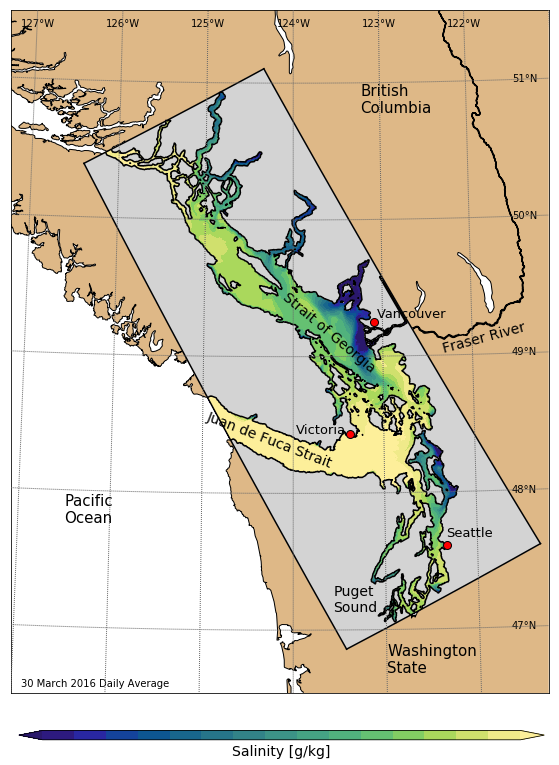

In [14]:
# Define Fraser coastline regions
bounds = [[0, 26000], [61500, 77000], [107500, 114000], [200000, 203000], [326000, 327000]]

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 13))

# Plot Model Domain
plot_map(ax, PNWrivers, bounds, grid_NEMO, T_NEMO)

fig.savefig('/home/bmoorema/Desktop/map.png', dpi=300, bbox_inches='tight')

Plot the SalishSeaCast domain.

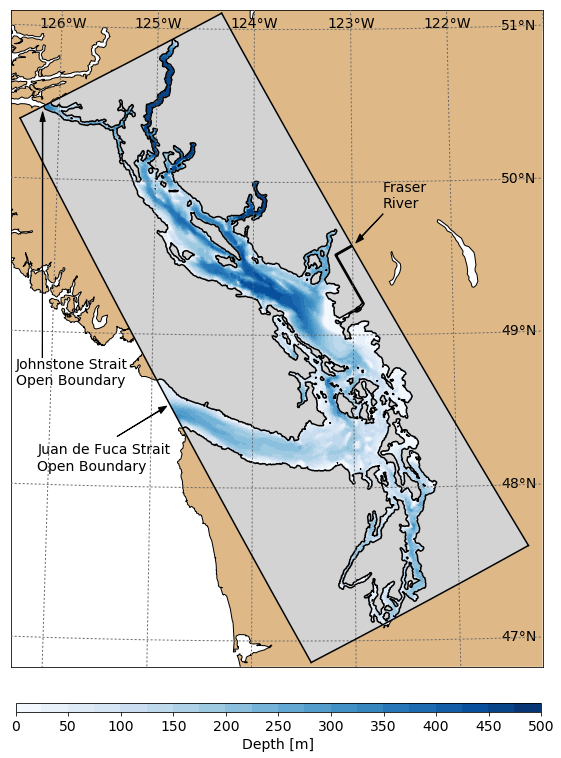

In [10]:
# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 12.5))

# Plot Model Domain
plot_domain(ax, grid_NEMO)

fig.savefig('/home/bmoorema/Desktop/domain.eps', transparent=True, dpi=300, bbox_inches='tight')

Plot station locations.

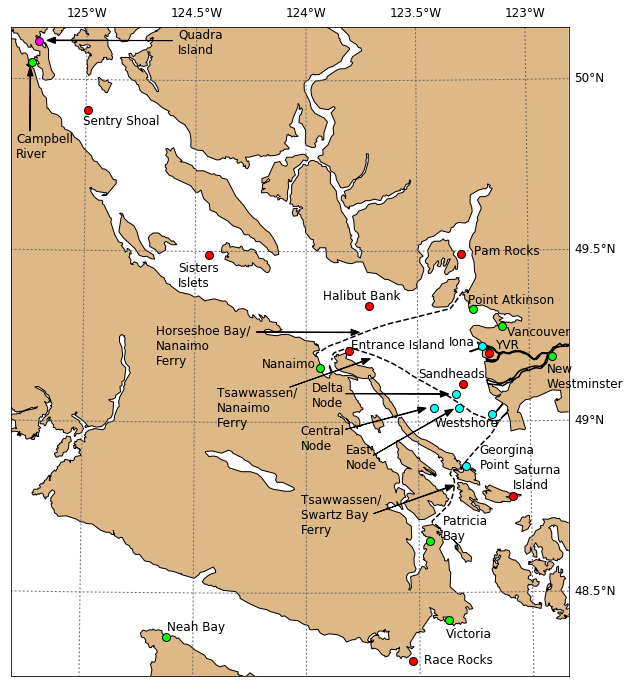

In [54]:
# Define Fraser coastline regions
bounds = [[72000, 77000], [200000, 203000], [326000, 327000]]

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 13))

plot_stations(ax, PNWrivers, bounds)

fig.savefig('/home/bmoorema/Desktop/stations.eps', transparent=True, dpi=300, bbox_inches='tight')

In [50]:
FraserMain = [
    'BBAR', 'COTR', 'DOGC', 'FRCN', 'HARR', 'LFRA', 'MFRA',
    'MORK', 'NARC', 'SETN', 'TABR', 'TWAC', 'UFRA',
]

FraserBasin = [
    'ADMS', 'BBAR', 'BIGC', 'BLAR', 'BONP', 'BOWR', 'BRID', 'CARR',
    'CHES', 'CHIL', 'CHIR', 'CHWK', 'CLWR', 'COTR', 'DEAD', 'DOGC',
    'DRIR', 'EUCH', 'EUCL', 'FRAN', 'FRCN', 'GRNL', 'HARR', 'HERR',
    'HORS', 'LCHL', 'LCHR', 'LEUT', 'LFRA', 'LILL', 'LNIC', 'LNRS',
    'LNTH', 'LSAL', 'LTRE', 'MAHD', 'MCGR', 'MFRA', 'MIDR', 'MORK',
    'MURT', 'MUSK', 'NARC', 'NAZR', 'NECR', 'NICL', 'QUES', 'SAJR',
    'SALR', 'SETN', 'SHUL', 'STHM', 'STUL', 'STUR', 'TABR', 'TAKL',
    'TASR', 'THOM', 'TWAC', 'UCHR', 'UEUT', 'UFRA', 'UNRS', 'UNTH',
    'USHU', 'UTRE', 'WILL',
]

FraserLakes = [
    'ADMS', 'BIGC', 'CARR', 'CLWR', 'EUCL', 'FRAN', 'HARR', 'LFRA',
    'LILL', 'LNRS', 'MURT', 'SETN', 'SHUL', 'STHM', 'STUL', 'TAKL',
    'TASR', 'THOM', 'UFRA', 'UNRS', 'USHU', 'UTRE',
]

In [733]:
# Load Cascadia bathymetry
y_slice = slice(2650, 3700)
x_slice = slice(3950, 5000)
x, y, z, p = bathy_readers.getcascadia('/ocean/bmoorema/research/data/cascadia/cascadia.bil')
z = z[x_slice, y_slice][::5, ::5]
z[z > 500] = 500
coords = p(*np.meshgrid(x[y_slice][::5], y[x_slice][::5]), inverse=True)

# Load belts
matlab_path = '/ocean/bmoorema/research/matlab/maps'
Mnlndcst = loadmat(os.path.join(matlab_path, 'Mnlndcst2'))['ncst']
Belts = loadmat(os.path.join(matlab_path, 'Belts2'))['Belts'][0][0]

/home/bmoorema/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/bmoorema/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/bmoorema/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


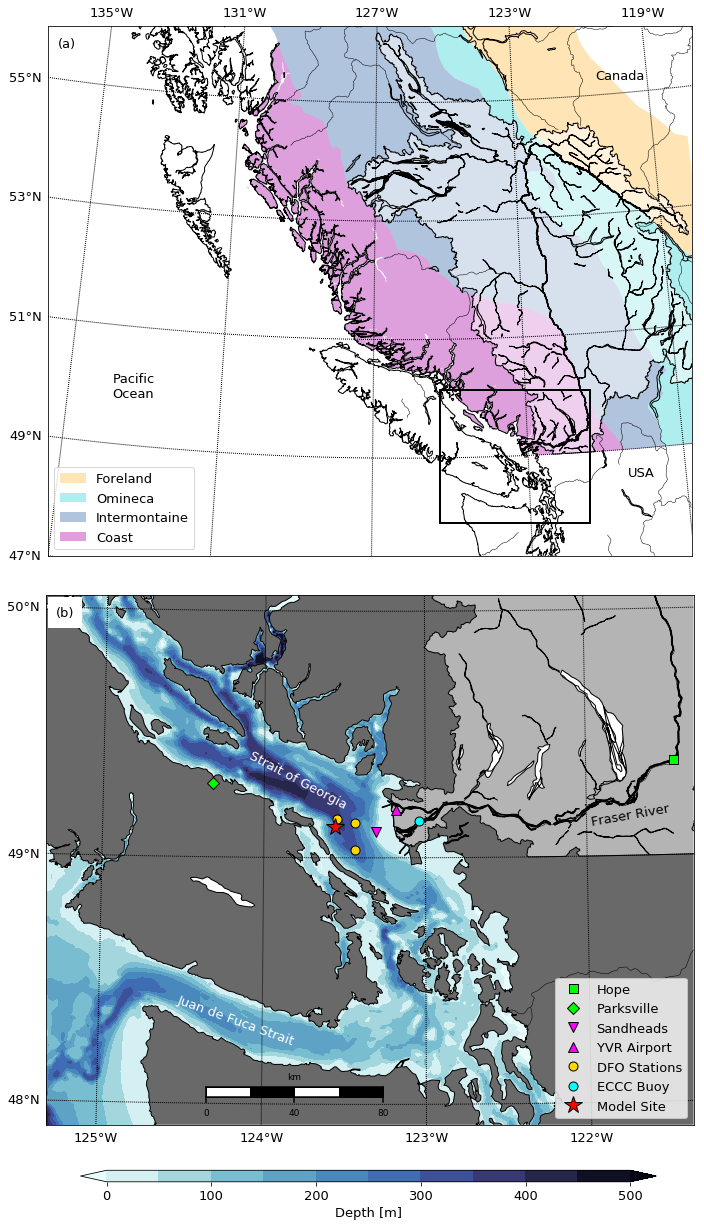

In [734]:
fig, axs = plt.subplots(2, 1, figsize=(10, 16))
fig.tight_layout()

# Define map window
ms = []
fills = [False, True]
w_maps = [[-135, -117.5, 47, 56], [-125.3, -121.3, 47.9, 50.05]]
lons = [range(-135, -117, 4), range(-126, -120)]
lats = [range(47, 57, 2), range(48, 51)]
locs = [2, 3]
for ax, fill, w_map, lon, lat, loc in zip(axs, fills, w_maps, lons, lats, locs):
    ms.append(plot_basemap(
        ax, w_map, color='dimgray', lons=lon, lats=lat, loc=loc, fill=fill,
    ))
    
# Plot belts
x, y = ms[0](Mnlndcst[:, 0], Mnlndcst[:, 1])
index = np.where(np.isnan(Mnlndcst[:, 0]))[0]
for i in range(1, 100):
    label = None
    if i == 1:
        label = 'Coast'
    chunk = slice(index[i-1]+1, index[i])
    axs[0].add_patch(Polygon(
        np.concatenate((x[chunk, np.newaxis][::100], y[chunk, np.newaxis][::100]), axis=1),
        edgecolor='none', facecolor='plum', label=label, zorder=-10,
    ))
beltcolors = ['moccasin', 'paleturquoise', 'lightsteelblue', 'w']
beltlabels = ['Foreland', 'Omineca', 'Intermontaine', None]
for i, color, label in zip(range(4), beltcolors, beltlabels):
    ncst = Belts[i][0][0][0]
    if i == 3:
        ncst[0, 0], ncst[-1, 0] = -117, -117
    x, y = ms[0](ncst[:, 0], ncst[:, 1])
    axs[0].add_patch(Polygon(
        np.concatenate((x[:, np.newaxis], y[:, np.newaxis]), axis=1),
        edgecolor='none', facecolor=color, label=label, zorder=-10,
    ))
    
data = True
if data:
    # Plot Cascadia bathymetry
    x_map, y_map = ms[1](*coords)
    c = axs[1].contourf(x_map, y_map, z, levels=range(0, 510, 50), cmap=cmocean.cm.ice_r, extend='both', zorder=-1)

    # Add Fraser watershed boundaries
    S = shapefile.Reader('/ocean/rich/more/mmapbase/bcgeo/FWNMDWTRSH/FWNMDWTRSH_polygon')
    for i, record in enumerate(S.records()):
        if record[9] == 'Fraser River':
            ncst = np.array(S.shape(i).points)
    for ax, m in zip(axs, ms):
        x, y = m(ncst[::10, 0], ncst[::10, 1])
        ax.add_patch(Polygon(
            np.concatenate((x[:, np.newaxis], y[:, np.newaxis]), axis=1),
            edgecolor='k', facecolor=[1, 1, 1, 0.5], zorder=0
        ))

    # Plot Fraser watershed rivers and main stem
    S = shapefile.Reader('/ocean/rich/more/mmapbase/bcgeo/FWRVRSPL/FWRVRSPL')
    for i, record in enumerate(S.records()):
        for wtshd in FraserBasin:
            if wtshd in record[15] and record[4] > 50:
                ncst = np.array(S.shape(i).points)
                if i == 2972:
                    ncst = ncst[:np.where(np.diff(ncst, axis=0) > 0.1)[0][0], :]
                for ax, m in zip(axs, ms):
                    x, y = m(ncst[::100, 0], ncst[::100, 1])
                    ax.plot(x, y, 'k-', linewidth=1)
        for wtshd in FraserMain:
            if wtshd in record[15] and record[16]  == 'NONE':
                ncst = np.array(S.shape(i).points)
                if i == 2972:
                    ncst = ncst[:np.where(np.diff(ncst, axis=0) > 0.1)[0][0], :]
                for ax, m in zip(axs, ms):
                    x, y = m(ncst[::100, 0], ncst[::100, 1])
                    ax.plot(x, y, 'k-', linewidth=1.5)

    # Plot Fraser watershed lakes
    S = shapefile.Reader('/ocean/rich/more/mmapbase/bcgeo/FWLKSPL/FWLKSPL')
    for i, record in enumerate(S.records()):
        for wtshd in FraserLakes:
            if wtshd in record[18] and record[4] > 500:
                ncst = np.array(S.shape(i).points)
                if i == 209874:
                    ncst = ncst[:np.where(np.diff(ncst, axis=0) > 0.1)[0][0], :]
                for ax, m in zip(axs, ms):
                    x, y = m(ncst[::100, 0], ncst[::100, 1])
                    ax.add_patch(Polygon(
                        np.concatenate((x[:, np.newaxis], y[:, np.newaxis]), axis=1),
                        edgecolor='k', facecolor='w',
                    ))

# Geographic Labels
axs[1].text(0.31, 0.69, 'Strait of Georgia', transform=axs[1].transAxes, rotation=-28, color='w')
axs[1].text(0.2, 0.23, 'Juan de Fuca Strait', transform=axs[1].transAxes, rotation=-20, color='w')
axs[1].text(0.84, 0.59, 'Fraser River', transform=axs[1].transAxes, rotation=10)
axs[0].text(0.1, 0.3, 'Pacific\nOcean', transform=axs[0].transAxes)
axs[0].text(0.85, 0.9, 'Canada', transform=axs[0].transAxes)
axs[0].text(0.9, 0.15, 'USA', transform=axs[0].transAxes)

# Stations
stations = {
    'Hope':         {'lon': -121.4522, 'lat': 49.3855, 'marker': 's', 'size': 9,  'label': True,  'color': 'lime'},
    'Parksville':   {'lon': -124.3200, 'lat': 49.3000, 'marker': 'D', 'size': 8,  'label': True,  'color': 'lime'},
    'Sandheads':    {'lon': -123.3033, 'lat': 49.1050, 'marker': 'v', 'size': 10, 'label': True,  'color': 'magenta'},
    'YVR Airport':  {'lon': -123.1844, 'lat': 49.1939, 'marker': '^', 'size': 10, 'label': True,  'color': 'magenta'},
    'DFO Stations': {'lon': -123.5497, 'lat': 49.1562, 'marker': 'o', 'size': 9,  'label': True,  'color': 'gold'},
    'DFO2':         {'lon': -123.4370, 'lat': 49.1400, 'marker': 'o', 'size': 9,  'label': False, 'color': 'gold'},
    'DFO3':         {'lon': -123.4368, 'lat': 49.0302, 'marker': 'o', 'size': 9,  'label': False, 'color': 'gold'},
    'ECCC Buoy':    {'lon': -123.0390, 'lat': 49.1480, 'marker': 'o', 'size': 9,  'label': True,  'color': 'cyan'},
    'Model Site':   {'lon': -123.5581, 'lat': 49.1248, 'marker': '*', 'size': 18, 'label': True,  'color': 'r'},
}
for station in stations.items():
    x, y = ms[1](station[1]['lon'], station[1]['lat'])
    label = None
    if station[1]['label']:
        label = station[0]
    axs[1].plot(
        x, y, linestyle='', marker=station[1]['marker'], color=station[1]['color'],
        markersize=station[1]['size'], markeredgecolor='k', label=label,
    )

# Final annotations
x, y = ms[0](w_maps[1][0], w_maps[1][2])
dx, dy = ms[0](w_maps[1][1], w_maps[1][3])
dx, dy = dx - x, dy - y
axs[0].add_patch(Rectangle([x, y], dx, dy, edgecolor='k', fill=False, linewidth=2))
ms[1].drawmapscale(-123.8, 48.05, -123, 49, 80, barstyle='fancy')
cax = fig.add_axes([0.11, -0.02, 0.8, 0.01])
cbar = fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth [m]')
handles, labels = axs[0].get_legend_handles_labels()
handles = handles[1:] + [handles[0]]
labels = labels[1:] + [labels[0]]
axs[0].legend(handles, labels, loc=3)
axs[1].legend(loc=4)
axs[0].text(0.015, 0.96, '(a)', transform=axs[0].transAxes)
axs[1].text(0.015, 0.96, '(b)', transform=axs[1].transAxes, zorder=11)
axs[1].add_patch(Rectangle((0.003, 0.94), 0.05, 0.055, color='w', transform=axs[1].transAxes, zorder=10))
plt.show()
fig.savefig('/home/bmoorema/Desktop/NewRiverFigs/map.pdf', dpi=300, bbox_inches='tight')